# Spatial relationships and operations
based on scipy2018-geospatial

## goals of the tutorial
- spatial projection conversion
- spatial relationships 
- spatial joins
- spatial operations

**based on the open data of:**
- [ISTAT](https://www.istat.it/it/archivio/222527) Italian National Institute of Statistic 
- [MIBACT](https://anagrafe.iccu.sbn.it/it/open-data/) Italian Ministery of Cultural Heritage


### requirements
- python knowledge
- pandas

### status 
*"Spatial is Special"*

---

In [115]:
%matplotlib inline
import os
import pandas as pd
import geopandas as gpd
import requests, zipfile, io

pd.options.display.max_rows = 10

## data setup
based on the previous tutorial

In [2]:
# download the data
zip_file_url = 'http://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012019.zip'
#request the file
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
#unzip the file
z.extractall()
# read the file
macroregions=gpd.read_file('Limiti01012019' + os.sep + 'RipGeo01012019' + os.sep + 'RipGeo01012019_WGS84.shp')

# Investigate the dataset of the italian public libraries
## from a dataframe to a geodataframe

we have a csv file with some point of interest where the coordinates are expressed in a column for the longitude and another for the latitude.

### the dataset of the public libraries
The italian Ministery of Cultural Heritage offers the open data with the location of public libraries in Italy
https://anagrafe.iccu.sbn.it/it/open-data/

here the link for the [download](http://opendata.anagrafe.iccu.sbn.it/territorio.zip)


This dataset is NOT archived in a spatial format.

**load the data with pandas**


In [3]:
libraries = pd.read_csv('http://opendata.anagrafe.iccu.sbn.it/territorio.zip', compression='zip', sep=';')

In [4]:
libraries.shape

(13994, 17)

In [5]:
libraries.head(5)

,codice-isil,codice-sbn,denominazione,indirizzo,frazione,cap,comune,codice istat comune,provincia,regione,codice istat provincia,latitudine,longitudine,telefono,fax,email,url
0,IT-AG0001,AGR27,Biblioteca della Soprintendenza per i beni cul...,Contrada S. Nicola,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3361677","13,5880717",+39 0922595830,NaN,NaN,NaN
1,IT-AG0005,NaN,Biblioteca dell'Archivio di Stato di Agrigento,Via Mazzini 185,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3221644312329","13,5886026454773",+39 0922602494,+39 0922613242,as-ag@beniculturali.it,http://www.archiviodistatoagrigento.benicultur...
2,IT-AG0006,PBED8,Biblioteca del Seminario vescovile,Piazza don Minzoni,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3137125","13,5749656",+39 092220226,+39 0922490024,NaN,NaN
3,IT-AG0007,AGR01,Biblioteca Comunale Franco La Rocca,Piazzale Aldo Moro n. 3,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3096114156152","13,5861396789551",+39 0922595166,+39 0922401246,biblioteca.larocca@comune.agrigento.it,http://www.opacagrigento.it/biblioteche/bi_1.html
4,IT-AG0008,NaN,Biblioteca comunale Santo Spirito. Sezione est...,Via Belvedere 127,Giardina Gallotti,92010.0,Agrigento,84001,Agrigento,SICILIA,84,"37,4050904","13,5291051",+39 0922410117,NaN,NaN,NaN


In [6]:
libraries.columns

Index(['codice-isil', 'codice-sbn', 'denominazione', 'indirizzo', 'frazione',
       'cap', 'comune', 'codice istat comune', 'provincia', 'regione',
       'codice istat provincia', 'latitudine', 'longitudine', 'telefono',
       'fax', 'email', 'url'],
      dtype='object')

we can use the columns *latitudine* and *longitudine* to plot a map

note:<br>
the **separator** of the decimal is with the **comma** and not with the **dot**.<br/>
We need to change it!

In [7]:
libraries.latitudine = pd.to_numeric(libraries.latitudine.str.replace(",","."))
libraries.longitudine = pd.to_numeric(libraries.longitudine.str.replace(",","."))

We also to check the presence of NULL values

In [8]:
libraries.latitudine.isnull().values.sum()

48

we can't work with the rows with NULL values

In [9]:
libraries = libraries[libraries.latitudine.isnull() == False]

now we are ready to create the geodataframe.
the operation are:
- creation of a geometry column based on the WKT syntax
- transform the DataFrame in GeoDataFrame

In [10]:
# we need shapely to create the Point geometry
from shapely.geometry import Point

In [11]:
libraries = gpd.GeoDataFrame(
    libraries.drop(['longitudine', 'latitudine'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(libraries.longitudine, libraries.latitudine)])

... and now we can plot the map!!!

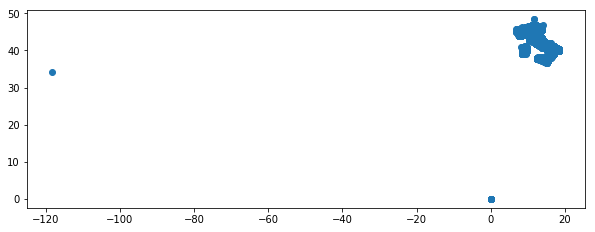

In [12]:
libraries.plot(figsize=(10,10))

there are some mistakes!!!

we plot the dots over the macro-regions of Italy

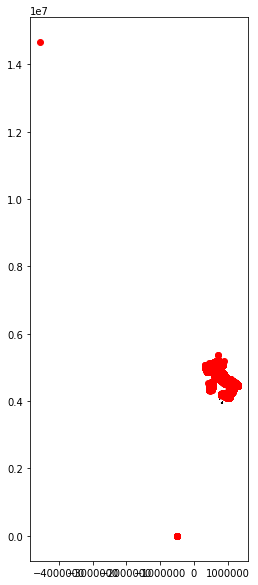

In [13]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
libraries.to_crs({'init': 'epsg:32632'}).plot(ax=ax,color="red")

## identify the boundary of the two datasets
#### calculate  the bounds

In [14]:
italy_bounds = macroregions.to_crs({'init': 'epsg:4326'}).bounds

In [15]:
italy_bounds

,minx,miny,maxx,maxy
0,6.626621,43.775663,11.427673,46.635187
1,9.197912,43.731892,13.918853,47.091784
2,9.686700,40.784734,14.027645,44.472707
3,13.018488,37.915754,18.520382,42.895081
4,8.130770,35.492916,15.652795,41.313250


**italy**<br/>
coordinates of the boundary: low left point and top right point

In [16]:
print(italy_bounds.minx.min(),italy_bounds.miny.min(),italy_bounds.maxx.max(),italy_bounds.maxy.max())

6.626621368537681 35.49291569024885 18.520381599098922 47.09178374646218


**libraries**

In [17]:
print(libraries.bounds.minx.min(),libraries.bounds.miny.min(),libraries.bounds.maxx.max(),libraries.bounds.maxy.max())

-118.241653 0.0 18.491521 48.426567


*data and map show us that the boundaries are not equals!*

---
# Spatial relationships 
## how two spatial objects relate to each other 

![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

## Relationships between individual objects

Eg.<br>
Is this library located in the north-west Italian macro-region?

we need the north-west italian macro-region in wgs84

In [18]:
northwest = macroregions.to_crs({'init': 'epsg:4326'})[macroregions.COD_RIP==1].geometry[0]

In [19]:
northwest

we choose a libraries in Torino (north west italy)

In [20]:
libraries[libraries.comune == 'Torino'].head(1)

,codice-isil,codice-sbn,denominazione,indirizzo,frazione,cap,comune,codice istat comune,provincia,regione,codice istat provincia,telefono,fax,email,url,geometry
12105,IT-TO0071,TO0D8,Biblioteca provinciale di filosofia San Tommas...,Via Rosario di Santa Fé 7,NaN,10134.0,Torino,1272,Torino,PIEMONTE,1,+39 011.3133162,+39 011.3133163,TO0071@biblioteche.reteunitaria. piemonte.it,http://http://www.domenicani.it/studio/bibliot...,POINT (7.650277099999999 45.0351306)


In [21]:
alibraryinturin = libraries[libraries['codice-sbn'] == 'TO0D8'].reindex().geometry.values[0]

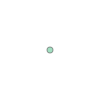

In [22]:
alibraryinturin

## within relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;it's the point inside the area?

In [23]:
alibraryinturin.within(northwest)

True

## contain relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;does the area contain the point?

In [24]:
northwest.contains(alibraryinturin)

True

we can iterate the operation for each point

_very slow!_

In [25]:
idx_libraries = []
for index,row in libraries.iterrows():
    point = row.geometry
    if point.within(northwest):
        idx_libraries.append(index)
libraries_northwest = libraries[libraries.index.isin(idx_libraries)]
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [26]:
libraries_northwest.shape

(3875, 16)

... or apply a lambda function to add an attribute<br/>
(*is_nw* => it's in nort west Italy?)

In [27]:
libraries['is_nw'] = libraries.geometry.apply(lambda x: x.within(northwest))
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [28]:
libraries[libraries.is_nw].shape

(3875, 17)

or simple filter...

In [29]:
libraries_northwest = libraries[libraries.within(northwest)]
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [30]:
libraries_northwest.shape

(3875, 17)

<div class="alert alert-info" style="font-size:120%">
<b>REFERENCE</b>: <br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):
<ul>
    <li>`equals`</li>
<li>`contains`</li>
<li>`crosses`</li>
<li>`disjoint`</li>
<li>`intersects`</li>
<li>`overlaps`</li>
<li>`touches`</li>
<li>`within`</li>
<li>`covers`</li>
</ul>


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.


See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations. 

# Spatial Joins
You can create a join like the usual [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) between pandas dataframe by using a spatial relationship with the function [geopandas.sjoin](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html)

In [31]:
libraries_and_macroregions = gpd.sjoin(macroregions.to_crs({'init': 'epsg:4326'}), 
                          libraries, how='inner', op='contains', lsuffix='left', rsuffix='right')
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [32]:
libraries_and_macroregions.columns

Index(['COD_RIP', 'DEN_RIP', 'SHAPE_Leng', 'SHAPE_Area', 'geometry',
       'index_right', 'codice-isil', 'codice-sbn', 'denominazione',
       'indirizzo', 'frazione', 'cap', 'comune', 'codice istat comune',
       'provincia', 'regione', 'codice istat provincia', 'telefono', 'fax',
       'email', 'url', 'is_nw'],
      dtype='object')

In [33]:
libraries_and_macroregions.head(5)

,COD_RIP,DEN_RIP,SHAPE_Leng,SHAPE_Area,geometry,index_right,codice-isil,codice-sbn,denominazione,indirizzo,...,comune,codice istat comune,provincia,regione,codice istat provincia,telefono,fax,email,url,is_nw
0,1,Nord-Ovest,2.670894e+06,5.792680e+10,(POLYGON ((8.486071903347419 44.30831978653275...,2162,IT-BS0111,NaN,Biblioteca comunale,Piazzale Donatori di Sangue 2,...,Niardo,17118,Brescia,LOMBARDIA,17,+39 0364330123,+39 0364330254,biblioteca@comune.niardo.bs.it,http://www.comune.niardo.bs.it/biblioteca,True
0,1,Nord-Ovest,2.670894e+06,5.792680e+10,(POLYGON ((8.486071903347419 44.30831978653275...,2360,IT-BS0515,NaN,Biblioteca comunale,"Via dei Nobili, 12",...,Lozio,17095,Brescia,LOMBARDIA,17,+39 0364494280,NaN,biblioteca@comune.lozio.bs.it,http://opac.provincia.brescia.it/library/bibli...,True
0,1,Nord-Ovest,2.670894e+06,5.792680e+10,(POLYGON ((8.486071903347419 44.30831978653275...,1332,IT-BG0263,LO172,Biblioteca comunale,Via Locatelli 8,...,Vilminore di Scalve,16243,Bergamo,LOMBARDIA,16,+39 034651014,+39 034651694,comune.vilminore@tiscali.it,http://www.comune.vilminore.bg.it/Organizzazio...,True
0,1,Nord-Ovest,2.670894e+06,5.792680e+10,(POLYGON ((8.486071903347419 44.30831978653275...,2128,IT-BS0058,NaN,Biblioteca comunale,Via G. Marconi 8/d,...,Ceto,17050,Brescia,LOMBARDIA,17,+39 0364434018,+39 0364434418,biblioteca@comune.ceto.bs.it,http://www.comune.ceto.bs.it,True
0,1,Nord-Ovest,2.670894e+06,5.792680e+10,(POLYGON ((8.486071903347419 44.30831978653275...,2100,IT-BS0024,NaN,Biblioteca comunale,Via Re 2,...,Braone,17027,Brescia,LOMBARDIA,17,+39 0364434043,NaN,NaN,NaN,True


... and now you can investigate the new geodataframe

In [34]:
total_libraries_for_macroregion = libraries_and_macroregions.groupby(['DEN_RIP']).size().to_frame('size').reset_index().sort_values(['size', 'DEN_RIP'], ascending=False)

In [35]:
total_libraries_for_macroregion.rename(columns={'size':'total','DEN_RIP':'macroregion'},inplace=True)

In [36]:
total_libraries_for_macroregion.set_index('macroregion',inplace=True)

In [37]:
total_libraries_for_macroregion

,total
macroregion,
Nord-Ovest,3875
Nord-Est,2918
Centro,2875
Sud,2695
Isole,1474


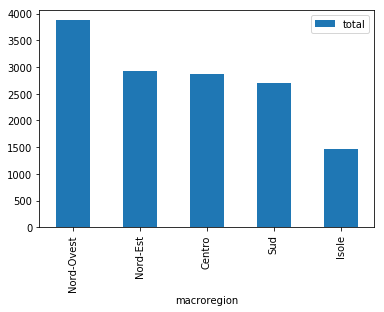

In [38]:
total_libraries_for_macroregion.plot.bar()


<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN </b>= *transferring attributes from one layer to another based on their spatial relationship*<br/>

Different parts of this operations:
<ul>
    <li>The GeoDataFrame to which we want add information</li>
    <li>The GeoDataFrame that contains the information we want to add</li>
    <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
    <li>The type of join: left or inner join</li>
</ul>


---
# Spatial operations 
GeoPandas provide analysis methods that return new geometric objects (based on shapely)

See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

## Es. buffer
*object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)*

    Returns an approximate representation of all points within a given distance of the this geometric object.

In [86]:
alibraryinturin_32632 = libraries.to_crs('epsg:32632')[libraries['codice-sbn'] == 'TO0D8'].reindex().geometry.values[0]

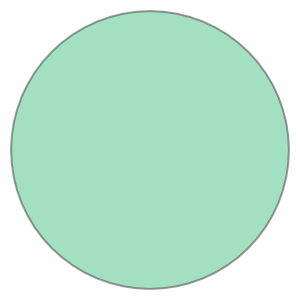

In [102]:
alibraryinturin_32632.buffer(9000) # a circle with a ray of 9000 meters

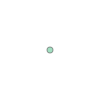

In [87]:
alibraryinturin_32632

## Es. simplify

*object.simplify(tolerance, preserve_topology=True)*

    Returns a simplified representation of the geometric object.


In [73]:
northwest_32632 = macroregions[macroregions.COD_RIP==1].geometry[0]

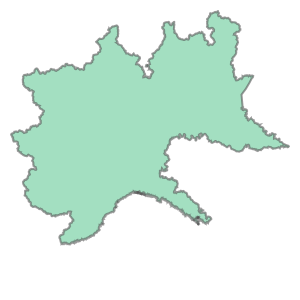

In [74]:
northwest_32632

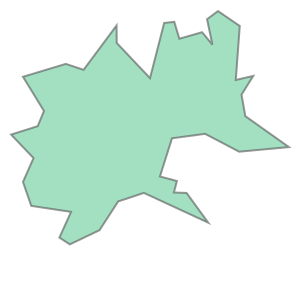

In [85]:
northwest_32632.simplify(10000,preserve_topology=False)

## Es. symmetric_difference
*object.symmetric_difference(other)*

    Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object.


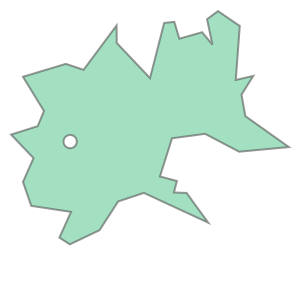

In [103]:
northwest_32632.simplify(10000,preserve_topology=False).symmetric_difference(alibraryinturin_32632.buffer(9000))

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.readthedocs.io/en/latest/reference.html">http://geopandas.readthedocs.io/en/latest/reference.html</a></li>
    </ul>



---
# Aggregation with dissolve

Spatial data are often more granular than we need. For example, we have the data of the macro-regions but we don't have a geometry with the border of Italy.

If we have a columns to operate a *groupby* we can solve it but to create the geometry we need the function *dissolve*.



In [109]:
macroregions['nation']='italy'

In [110]:
italy = macroregions[['nation', 'geometry']]

In [112]:
italy = italy.to_crs({'init': 'epsg:4326'}).dissolve(by='nation')
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


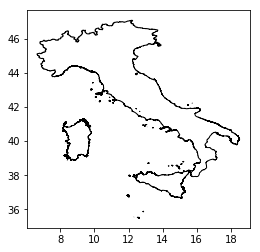

In [113]:
italy.plot(facecolor="none", edgecolor='black')

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

dissolve can be thought of as doing three things: (a) it **dissolves** all the geometries within a given group together into a single geometric feature (using the *unary_union* method), and (b) it **aggregates** all the rows of data in a group using *groupby.aggregate()*, and (c) it **combines** those two results.
    
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.org/aggregation_with_dissolve.html">http://geopandas.org/aggregation_with_dissolve.html</a></li>
 </ul>

---
# Exercise
- clean the dataset of the italian libraries with the points outside italy
- filter, by using a spatial relationship, all the libraries of an italian municipality
- choose a library in Bolzano and a library in Siracusa and calculate the geodentic distance in meters<br/>suggestion: *.distance(other)*
---